# Variant Calling RNA/DNA

In [3]:
from sequana import *
%matplotlib inline
from pylab import *
import pandas as pd

In [4]:
ginf = GFF3("references/infantum.gff")
lengths = ginf.df.query("genetic_type=='region'").stop.values
names =  [int(x) for x in ginf.df.query("genetic_type=='region'").Name.values]


In [5]:
def get_df_from_inf(filename):

    ginf = GFF3("references/infantum.gff")
    lengths = ginf.df.query("genetic_type=='region'").stop.values
    seqid =  ginf.df.query("genetic_type=='region'").seqid.values
    names =  [int(x) for x in ginf.df.query("genetic_type=='region'").Name.values]
    mapper = dict([(k,v) for k,v in zip(seqid, names)])

    inf = VCF_freebayes(filename)
    inf.df
    inf.df["chrom_name"] = [mapper[x] for x in inf.df['chr'].values]
    inf._df = inf.df.query("type=='snp'")
    inf.df['frequency'] = [float(x) for x in inf.df['frequency']]
    inf.df['strand_balance'] = [float(x) for x in inf.df['strand_balance']]
    return inf

In [6]:
def get_df_from_tar(filename):

    g = GFF3("references/tarentolae.gff")
    lengths = g.df.query("genetic_type=='region'").stop.values
    seqid =  g.df.query("genetic_type=='region'").seqid.values
    names =  [x for x in g.df.query("genetic_type=='region'").Name.values]
    import pandas as pd
    mapper = dict([(x, y) for x,y in zip(seqid, names) if pd.isna(y) is False])
    names = list(mapper.keys())

    valid_ctgs = [k for k,v in mapper.items() if v] + list(names)

    inf = VCF_freebayes(filename)
    _ = inf.df
    inf._df = inf.df.query("chr in @valid_ctgs")
    inf.df["chrom_name"] = [mapper[x] for x in inf.df['chr'].values]
    inf._df = inf.df.query("type=='snp'")
    inf.df['frequency'] = [float(x) for x in inf.df['frequency']]
    inf.df['strand_balance'] = [float(x) for x in inf.df['strand_balance']]
    return inf


In [7]:
def get_df_from_tarinf(filename):
    from collections import defaultdict
    g = GFF3("references/tarentolae.gff")
    mapper = {}
    lengthst = defaultdict(int)
    for x in range(178):
        df = g.df.query("genetic_type=='region'")
        Name = df.iloc[x].Name
        if pd.isna(Name):
            pass
            #mapper[df.iloc[x].seqid] = 0
        else:
            mapper[df.iloc[x].seqid] = int(Name)
            lengthst[int(Name)] += df.iloc[x].stop - df.iloc[x].start
            
    g = GFF3("references/infantum.gff")
    lengths = g.df.query("genetic_type=='region'").stop.values
    names = g.df.query("genetic_type=='region'").seqid.values
    chrnames = list(range(1,36+1))
    for i,name in enumerate(names):
        mapper[name] = i+1

    names = list(mapper.keys())

    
    inf = VCF_freebayes(filename)
    _ = inf.df
    inf._df = inf.df.query("chr in @names")
    inf.df["chrom_name"] = [mapper[x] for x in inf.df['chr'].values]
    inf._df = inf.df.query("type=='snp'")
    inf.df['frequency'] = [float(x) for x in inf.df['frequency']]
    inf.df['strand_balance'] = [float(x) for x in inf.df['strand_balance']]
    inf._df['tag'] = ['tar' if x.startswith('BL') else 'inf' for x in inf.df['chr']]

    return inf





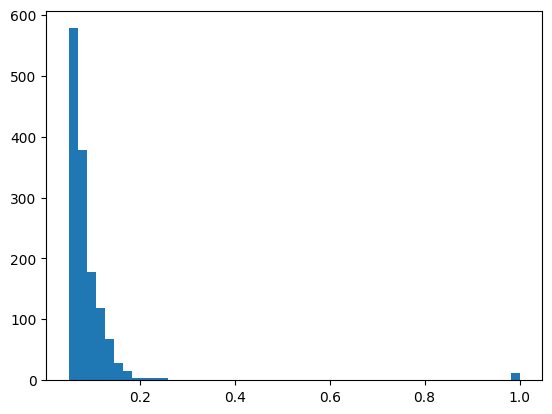

In [8]:
inf = get_df_from_inf("data/VCFs/all_on_inf/inf.raw.vcf")

_ = hist(inf.df.query("type=='snp' and chrom_name == 4").frequency.values, bins=50)


# number of homozygot SNPs per 100,000 bp (INF)

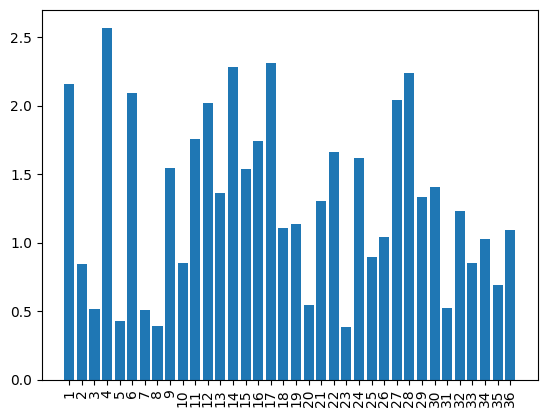

In [9]:
bar(x=range(1,37), height=(inf.df.query("frequency>0.8 and strand_balance>0.2 and strand_balance<0.8 and depth>40").groupby('chrom_name').count()['depth']).divide(lengths)*100000)
_ = xticks(range(1,37), names, rotation=90)

# TAR case

In [10]:
tar = get_df_from_inf("data/VCFs/all_on_inf/tar.raw.vcf")

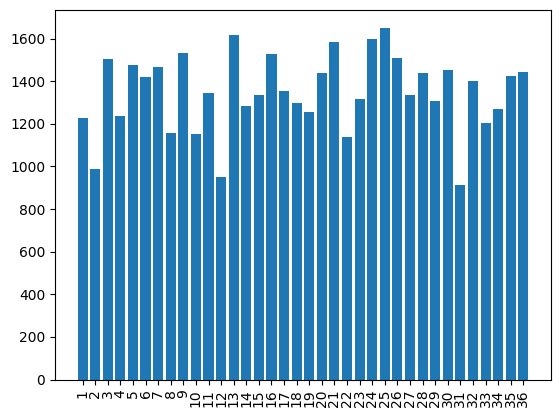

In [11]:
bar(x=range(1,37), height=(tar.df.query("frequency>0.8 and strand_balance>0.2 and strand_balance<0.8 and depth>40").groupby('chrom_name').count()['depth']).divide(lengths)*100000)
_ = xticks(range(1,37), names, rotation=90)

# Hyb case

In [13]:
hyb = get_df_from_inf("data/VCFs/all_on_inf/hyb.raw.vcf")

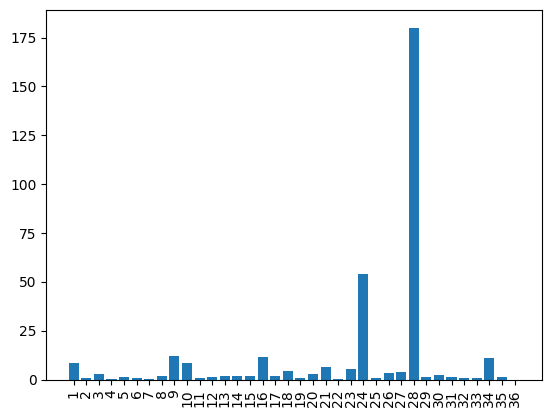

In [14]:
# chrom3 has no homozygous SNPs
res = hyb.df.query("frequency>0.8 and strand_balance>0.2 and strand_balance<0.8 and depth>40").groupby('chrom_name').count()['depth']
res.loc[3] = 0
res = res.divide(lengths) *100000
bar(x=range(1,37), height=res)
_ = xticks(range(1,37), names, rotation=90)

(0.0, 1.0)

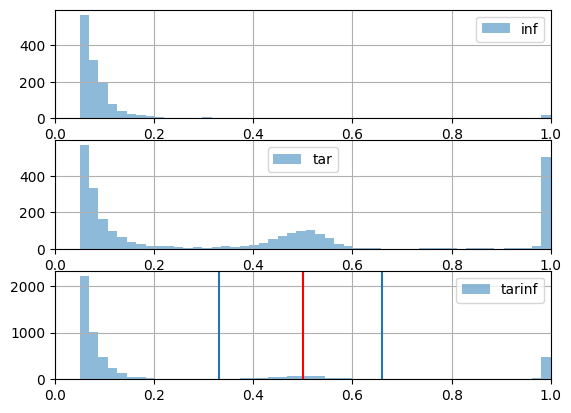

In [25]:
chrom_name = 17
score = 0

subplot(3,1,1)
inf.df.query("chrom_name==@chrom_name and freebayes_score>@score")['frequency'].hist(bins=50, alpha=0.5, label="inf"); legend()
xlim([0,1])

subplot(3,1,2)
tar.df.query("chrom_name==@chrom_name and freebayes_score>@score")['frequency'].hist(bins=50, alpha=0.5, label="tar"); legend()
xlim([0,1])

subplot(3,1,3)
hyb.df.query("chrom_name==@chrom_name and freebayes_score>@score and depth>20")['frequency'].hist(bins=50, alpha=0.5, label="tarinf"); legend()
axvline(0.33)
axvline(0.66)
axvline(0.5, color='r')

xlim([0,1])


In [21]:
inf = get_df_from_tarinf("data/VCFs/all_on_tarinf/inf.raw.vcf")

/tmp/ipykernel_3526544/2230163646.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
tar = get_df_from_tarinf("data/VCFs/all_on_tarinf/tar.raw.vcf")

/tmp/ipykernel_3526544/2230163646.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
hyb = get_df_from_tarinf("data/VCFs/all_on_tarinf/hyb.raw.vcf")


/tmp/ipykernel_3526544/2230163646.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.83it/s]


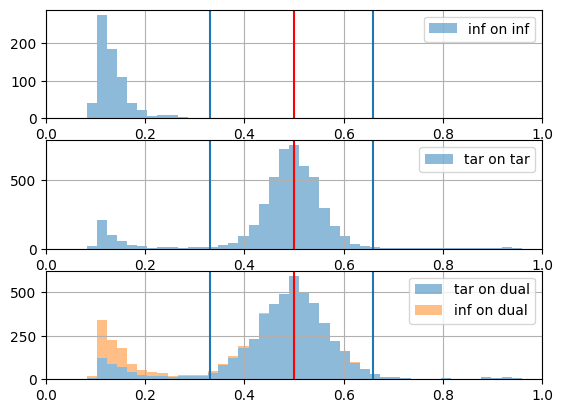

In [28]:
from tqdm import tqdm
for chrom_name in tqdm(range(1,37)):
    score = 10
    mindepth=10
    frequency = 0.1
    maxfreq=0.95
    clf()
    bins = linspace(0,1,50)
    
    subplot(3,1,1)
    inf.df.query("chrom_name==@chrom_name and freebayes_score>@score and frequency>@frequency and frequency<@maxfreq and depth>@mindepth")['frequency'].hist(bins=bins, alpha=0.5, label="inf on inf"); legend()
    xlim([0,1]); axvline(0.33); axvline(0.66); axvline(0.5, color='r')
    
    subplot(3,1,2)
    tar.df.query("chrom_name==@chrom_name and freebayes_score>@score  and frequency>@frequency  and frequency<@maxfreq  and depth>@mindepth")['frequency'].hist(bins=bins, alpha=0.5, label="tar on tar"); legend()
    xlim([0,1]); axvline(0.33); axvline(0.66); axvline(0.5, color='r')
    
    
    subplot(3,1,3)    
    T = hyb.df.query("chrom_name==@chrom_name and freebayes_score>@score  and frequency>@frequency and tag=='tar'  and frequency<@maxfreq  and depth>@mindepth")['frequency']
    I = hyb.df.query("chrom_name==@chrom_name and freebayes_score>@score  and frequency>@frequency and tag=='inf'  and frequency<@maxfreq  and depth>@mindepth")['frequency']
    hist([T, I], stacked=True, bins=bins, alpha=0.5)
    grid()
    
    legend(["tar on dual", "inf on dual"])    
    axvline(0.33); axvline(0.66); axvline(0.5, color='r'); xlim([0,1])
    savefig(f"images_and_results/all_on_tarinf/SNP_{chrom_name}.png")
# chrm1 = 3  on tarinf
# chrm2 = 2  on tar
# chr3: 2 on tar
# chr4: 2 on tar and maybe on hyb
# chr5: 2 on tar
# chr31: 4 on tar and hyb
# chr12: 2 on tar, maybe 4 on inf ?

In [30]:
hyb.df.query("chrom_name==29 and freebayes_score>10  and frequency>0.5 and tag=='tar' and depth>10")

,chr,position,depth,reference,alternative,freebayes_score,strand_balance,fisher_pvalue,ID,type,frequency,chrom_name,tag
106943,BLBS01000040.1,236,119,C,T,3827.260010,0.471,1.0,106944,snp,1.000,29,tar
106944,BLBS01000040.1,776,133,C,G,3016.870117,0.480,0.5508303164065116,106945,snp,0.737,29,tar
106945,BLBS01000040.1,2362,110,C,G,3588.379883,0.491,1.0,106946,snp,1.000,29,tar
106947,BLBS01000040.1,3318,116,G,C,2631.209961,0.482,0.9999999999999822,106948,snp,0.716,29,tar
106948,BLBS01000040.1,3338,122,G,C,2602.570068,0.470,0.8425609986218686,106949,snp,0.680,29,tar
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112218,BLBS01000041.1,868101,36,C,G,1051.819946,0.000,1.0,112219,snp,1.000,29,tar
112219,BLBS01000041.1,868317,75,T,C,2210.500000,0.351,1.0,112220,snp,0.987,29,tar
112220,BLBS01000041.1,868338,83,G,A,2233.790039,0.400,1.0,112221,snp,0.964,29,tar
112225,BLBS01000041.1,869422,121,T,G,3820.889893,0.479,1.0,112226,snp,1.000,29,tar


In [31]:
rna_hyb1 = get_df_from_tarinf("data/VCFs/RNA/hyb1.raw.vcf")
rna_hyb2 = get_df_from_tarinf("data/VCFs/RNA/hyb2.raw.vcf")
rna_hyb3 = get_df_from_tarinf("data/VCFs/RNA/hyb3.raw.vcf")
rna_inf1 = get_df_from_tarinf("data/VCFs/RNA/inf1.raw.vcf")
rna_inf2 = get_df_from_tarinf("data/VCFs/RNA/inf2.raw.vcf")
rna_inf3 = get_df_from_tarinf("data/VCFs/RNA/inf3.raw.vcf")
rna_tar1 = get_df_from_tarinf("data/VCFs/RNA/tar1.raw.vcf")
rna_tar2 = get_df_from_tarinf("data/VCFs/RNA/tar2.raw.vcf")
rna_tar3 = get_df_from_tarinf("data/VCFs/RNA/tar3.raw.vcf")


/tmp/ipykernel_3526544/2230163646.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3526544/2230163646.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3526544/2230163646.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ip

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.90it/s]


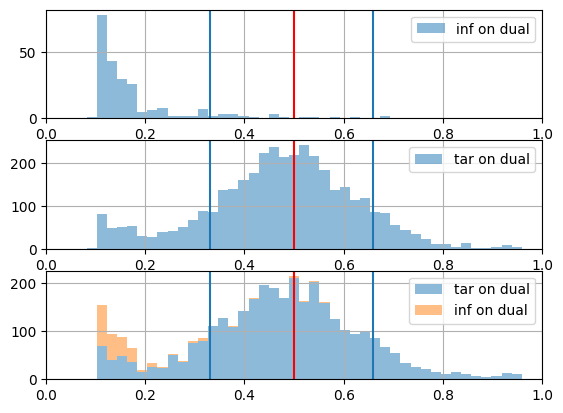

In [32]:

from tqdm import tqdm
for chrom_name in tqdm(range(1,37)):
    score = 10
    mindepth=10
    frequency = 0.1
    maxfreq=0.95
    clf()
    bins = linspace(0,1,50)
    
    subplot(3,1,1)
    rna_inf1.df.query("chrom_name==@chrom_name and freebayes_score>@score and frequency>@frequency and frequency<@maxfreq and depth>@mindepth")['frequency'].hist(
        bins=bins, alpha=0.5, label="inf on dual"); legend()
    xlim([0,1]); axvline(0.33); axvline(0.66); axvline(0.5, color='r')
    
    subplot(3,1,2)
    rna_tar1.df.query("chrom_name==@chrom_name and freebayes_score>@score  and frequency>@frequency  and frequency<@maxfreq  and depth>@mindepth")['frequency'].hist(
        bins=bins, alpha=0.5, label="tar on dual"); legend()
    xlim([0,1]); axvline(0.33); axvline(0.66); axvline(0.5, color='r')
    
    
    subplot(3,1,3)    
    T = rna_hyb1.df.query("chrom_name==@chrom_name and freebayes_score>@score  and frequency>@frequency and tag=='tar'  and frequency<@maxfreq  and depth>@mindepth")['frequency']
    I = rna_hyb1.df.query("chrom_name==@chrom_name and freebayes_score>@score  and frequency>@frequency and tag=='inf'  and frequency<@maxfreq  and depth>@mindepth")['frequency']
    hist([T, I], stacked=True, bins=bins, alpha=0.5)
    grid()
    
    legend(["tar on dual", "inf on dual"])    
    axvline(0.33); axvline(0.66); axvline(0.5, color='r'); xlim([0,1])
    savefig(f"images_and_results/RNA/SNP_{chrom_name}.png")
    
    savefig(f"images_and_results/RNA/SNP_{chrom_name}.png")